In [1]:
#first import dependencies, mainly numpyro
import argparse
import os
import time
from jax.config import config
config.update("jax_enable_x64", True)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
import pandas as pd
data = pd.read_pickle('/home/dkn16/data.pkl')
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs
#matplotlib.use("Agg")  # noqa: E402

In [2]:
# create artificial regression dataset
def get_data(pol=False,dim=256,x0=0,y0=0,freqs = 285):
    #idx=np.random.randint(1,6)
    #loc_idx=np.random.randint(48)
    
    #foreground
    if pol:
        sky = jnp.array(FGnopol+FGpol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    else:
        sky = jnp.array(FGnopol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #HI signal
    cosmos = jnp.array(HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,freqs))/1000
    cosmos=cosmos.reshape((dim*dim,freqs))/1000
    
    np.random.seed(0)
    X = jnp.linspace(0., 1., sky.shape[1])#,dtype = jnp.float64)
    #Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    #Y += sigma_obs * np.random.randn(N)
    #Y -= jnp.mean(Y)
    #Y /= jnp.std(Y)

    #assert X.shape == (N,)
    #assert Y.shape == (N,)

    X_test = jnp.linspace(0., 1.,sky.shape[1])#,dtype = jnp.float64)

    return X, sky+cosmos, X_test

In [23]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) / length_HI)
    
    k_fg = var * jnp.exp(-0.5 * deltaXsq)
    k_HI = 1.0e-10*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg

def kernel_pol(X, Z, var, length,var_pol,length_pol,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltapol = jnp.power((X[:, None] - Z) / length_pol, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) *100/ length_HI)
    
    k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
    k_pol = 1.0e-6*var_pol * jnp.exp(-0.5 * deltapol)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg

def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var_fg_std = numpyro.sample("varfg_std", dist.HalfNormal(1))
    
    length_fg_alpha = numpyro.sample("length_fg_alpha",dist.LogNormal(1,3))
    length_fg_beta = numpyro.sample("length_fg_beta",dist.LogNormal(0,3))
    
    #var = 100
    noise = numpyro.sample("kernel_noise", dist.HalfNormal(1))
    
    var_HI_std = numpyro.sample("varHI_std", dist.HalfNormal(1))
    length_HI_std = numpyro.sample("lengthHI_std", dist.HalfNormal(2))
    
    
    var_pol_std = numpyro.sample("varpol_std", dist.HalfNormal(5))
    
    length_pol_alpha = numpyro.sample("length_pol_alpha",dist.LogNormal(2,3))
    length_pol_beta = numpyro.sample("length_pol_beta",dist.LogNormal(0,3))
    
    var_HI = numpyro.sample("kernel_varHI", dist.HalfNormal(jnp.ones(Y.shape[0])*var_HI_std))
    length_HI = numpyro.sample("kernel_lengthHI",dist.HalfNormal(jnp.ones(Y.shape[0])*length_HI_std))
    var_fg = numpyro.sample("kernel_var", dist.HalfNormal(jnp.ones(Y.shape[0])*var_fg_std))
    length_fg = numpyro.sample("kernel_length", dist.InverseGamma(jnp.ones(Y.shape[0])*length_fg_alpha,jnp.ones(Y.shape[0])*length_fg_beta))
    var_pol = numpyro.sample("kernel_varpol", dist.HalfNormal(jnp.ones(Y.shape[0])*var_pol_std))
    length_pol = numpyro.sample("kernel_lengthpol", dist.InverseGamma(jnp.ones(Y.shape[0])*length_pol_alpha,jnp.ones(Y.shape[0])*length_pol_beta))

    # compute kernel
    X=jnp.repeat(jnp.array([X]),Y.shape[0],axis=0)
    noise=jnp.repeat(jnp.array([noise]),Y.shape[0],axis=0)
    # compute kernel
    vmap_args = (
        X,X,var_fg,length_fg,var_pol,length_pol,var_HI,length_HI,noise
    )
    
    k = vmap(
        lambda X,  Z,var_fg,length_fg,var_pol,length_pol,var_HI,length_HI,noise: kernel_pol(
            X, Z,var_fg,length_fg,var_pol,length_pol,var_HI,length_HI,noise
        )
    )(*vmap_args)
    #k = kernel_pol(X, X, var_fg, length_fg,var_pol,length_pol,var_HI,length_HI, noise)

    # sample Y according to the standard gaussian process formula
    #print(k.shape)
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((Y.shape[0],Y.shape[1])), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model,init_strategy, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy,target_accept_prob=0.8,max_tree_depth=8)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=1,
        thinning=1,
        progress_bar= True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel_pol(X_test, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)
    k_pX = kernel_pol(X_test, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)
    k_XX = kernel_pol(X, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    #sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
    #    rng_key, X_test.shape[:1]
    #)
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean#, mean + sigma_noise




def main():
    X, Y, X_test = get_data(pol=True,dim=64,x0=183,y0=0,freqs=150)

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    samples = run_inference(model, "median", rng_key, X, Y)
    return samples

    
def predict_fg(samples,batch):
    X, Y, X_test = get_data(pol=True,dim=64,x0=183,y0=0,freqs=150)
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    X=jnp.repeat(jnp.array([X]),Y.shape[0],axis=0)
    noise=samples["kernel_noise"][-1:-1*batch-1:-1]
    # do prediction
    
    means = []
    for i in range(batch):
        vmap_args = (
            random.split(rng_key_predict, X.shape[0]),
            X,
            Y,
            X,
            samples["kernel_var"][-1*(i+1)],
            samples["kernel_length"][-1*(i+1)],
            samples["kernel_varpol"][-1*(i+1)],
            samples["kernel_lengthpol"][-1*(i+1)],
            samples["kernel_varHI"][-1*(i+1)],
            samples["kernel_lengthHI"][-1*(i+1)],
            #samples["kernel_noise"][-1:-1*batch-1:-1],
        )
        
        means.append(vmap(
            lambda rng_key,X,Y,X_test, var, length,var_pol, length_pol,var_HI, length_HI: predict(
                rng_key, X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise[i]
            )
        )(*vmap_args))

    mean_prediction = np.mean(means, axis=0)
    percentiles = np.percentile(means, [5.0, 95.0], axis=0)
    
    return X_test,mean_prediction,percentiles,samples
    # plt.savefig("gp_plot.pdf")

In [24]:
numpyro.set_platform('gpu')
numpyro.set_host_device_count(1)
#samples = main()
X_test,mean_prediction,percentiles,samples = predict_fg(samples,40)

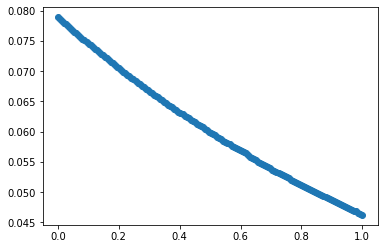

In [25]:
plt.fill_between(X_test, percentiles[0, 0,:], percentiles[1, 0,:], color="lightblue")
plt.scatter(X,Y[0])
plt.plot(X_test,mean_prediction[0])


In [43]:
sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy')

In [29]:
x0 = 183
y0 = 0
dim = 64
freqs = 150
cosmos = HI[x0:x0+dim,y0:y0+dim,0:freqs]
    
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(dim*dim,freqs)

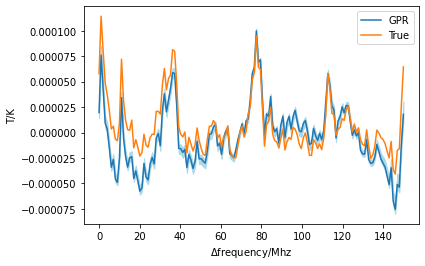

In [49]:
i=45+18*64
#cosmos = HI[0:64,0:64].reshape(64*64,285)
plt.plot(X*freqs,Y[i]-mean_prediction[i])

plt.plot(X*freqs,cosmos[i]/1000)
plt.fill_between(X_test*freqs,Y[i]-percentiles[0, i,:], Y[i]-percentiles[1, i,:], color="lightblue")
plt.xlabel(r'$\Delta$frequency/Mhz')
plt.ylabel(r'T/K')
plt.legend(['GPR','True'])

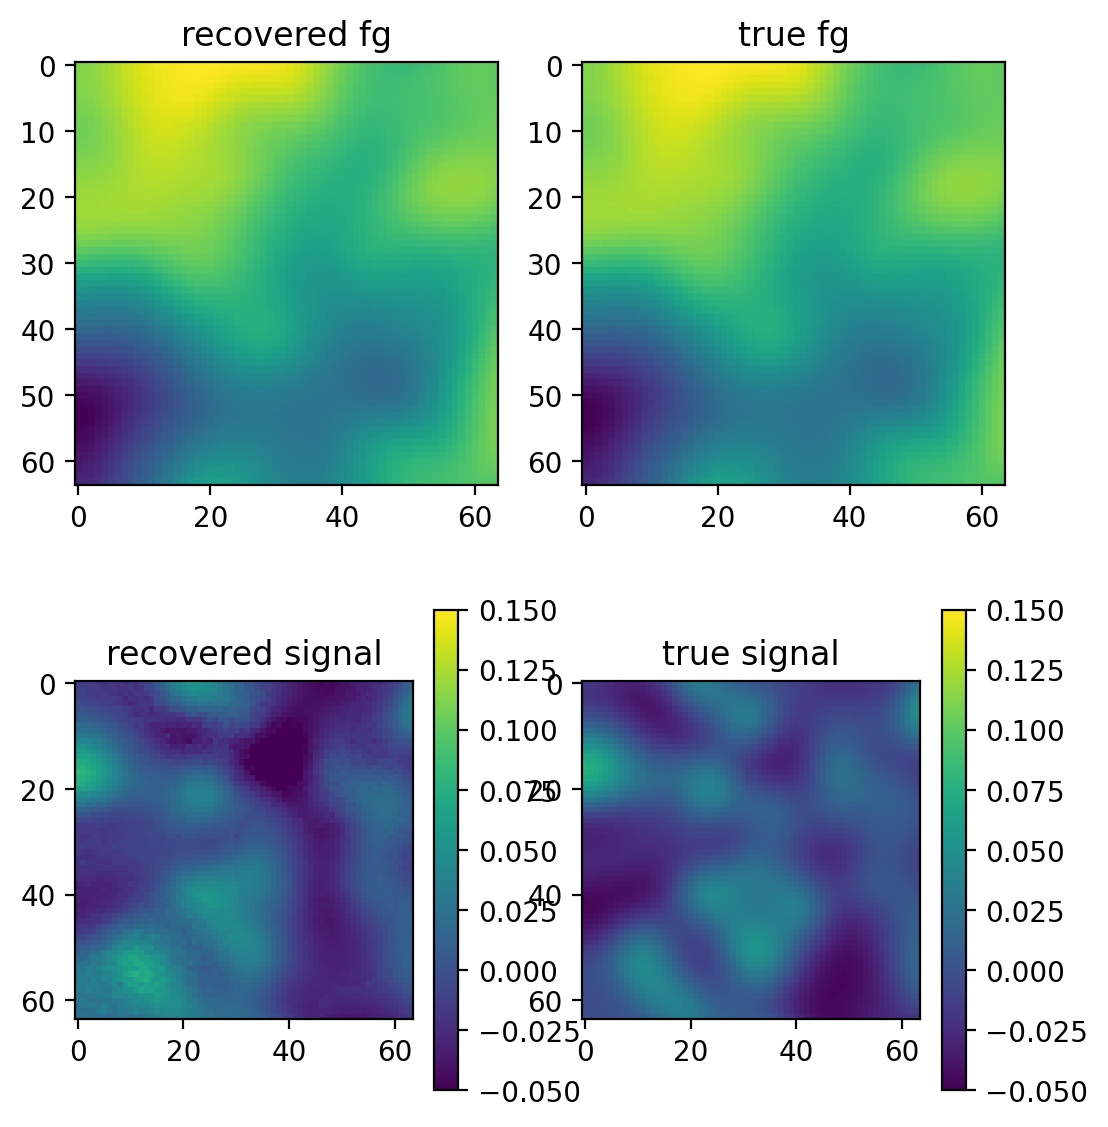

In [48]:
i=10
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(dim,dim))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y[:,i].reshape(dim,dim))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y[:,i]-mean_prediction[:,i]).reshape(dim,dim)*1000,vmax=0.15,vmin=-0.05)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(dim,dim),vmax=0.15,vmin=-0.05)
plt.title('true signal')
plt.colorbar()

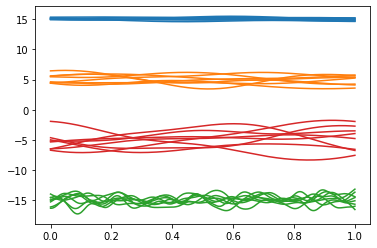

In [35]:
X, Y, X_test = get_data()
k1 = kernel(X, X,  0.052016747, 0.23297304,0.1,0.1, 1.81647456)
k2 = kernel(X, X,  1.52016747, 0.23297304,0.1,0.1, 1.81647456)
k3 = kernel(X, X,  0.52016747, 0.23297304,0.1,0.1, 1.81647456)
k4 = kernel(X, X,  0.52016747, 0.03297304,0.1,0.1, 1.81647456)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((2,2,X.shape[0])), covariance_matrix=[[k1,k2],[k3,k4]]),
        #obs=Y,
        rng_key= rng_key,sample_shape=(8,)
    )
for i in range(8):
    plt.plot(X,samp[i][0][0]+15,c='tab:blue')
    plt.plot(X,samp[i][1][0]+5,c='tab:orange')
    plt.plot(X,samp[i][0][1]-5,c='tab:red')
    plt.plot(X,samp[i][1][1]-15,c='tab:green')

In [41]:
numpyro.sample("kernel_var", dist.InverseGamma(5,1),rng_key= rng_key,sample_shape=(32,))

DeviceArray([0.18097177, 0.18578462, 0.38366776, 0.15152374, 0.15650578,
             0.1917564 , 0.08690369, 0.24011778, 0.32418255, 0.22211597,
             0.2275647 , 0.11958385, 0.15307461, 0.33358189, 0.3349686 ,
             0.27367715, 0.31312845, 0.19623936, 0.34858856, 0.21929288,
             0.17914835, 0.14264662, 0.48178938, 0.2833664 , 0.14167706,
             0.19604383, 0.14673859, 0.13803312, 0.37511712, 0.16335968,
             0.13393248, 0.27858108], dtype=float64)

In [30]:
percentiles.shape

(2, 10, 150)

In [125]:
Y.shape

(4096, 150)

In [110]:
k = kernel(X, X, 0.52016747, 0.23297304, 1.81647456)
jnp.mean(dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k).log_prob(Y))

DeviceArray(1264.82178955, dtype=float64)

In [170]:
samples

{'kernel_length': DeviceArray([0.42302552, 0.42301878, 0.42302362, 0.42301987, 0.42302611,
              0.42302386, 0.42301263, 0.42300984, 0.42300949, 0.42300693,
              0.42301815, 0.42301443, 0.42302797, 0.42303227, 0.42302964,
              0.4230277 , 0.42303511, 0.42303283, 0.42303401, 0.42303393,
              0.4230301 , 0.42302349, 0.42302522, 0.42302567, 0.42302858,
              0.42303519, 0.42303757, 0.42303275, 0.42303534, 0.42304212,
              0.42303208, 0.42303007, 0.42303806, 0.42303085, 0.42302919,
              0.42302831, 0.42302581, 0.42301978, 0.42301602, 0.42301501,
              0.42300887, 0.42299479, 0.42298329, 0.42298619, 0.42299007,
              0.42299533, 0.422989  , 0.42298821, 0.42299028, 0.42298966],            dtype=float64),
 'kernel_noise': DeviceArray([1.80610243, 1.80609536, 1.80603133, 1.80598893, 1.8059467 ,
              1.80592032, 1.8059154 , 1.80593716, 1.80591137, 1.80589166,
              1.80587565, 1.80587742, 1.80590157, 1

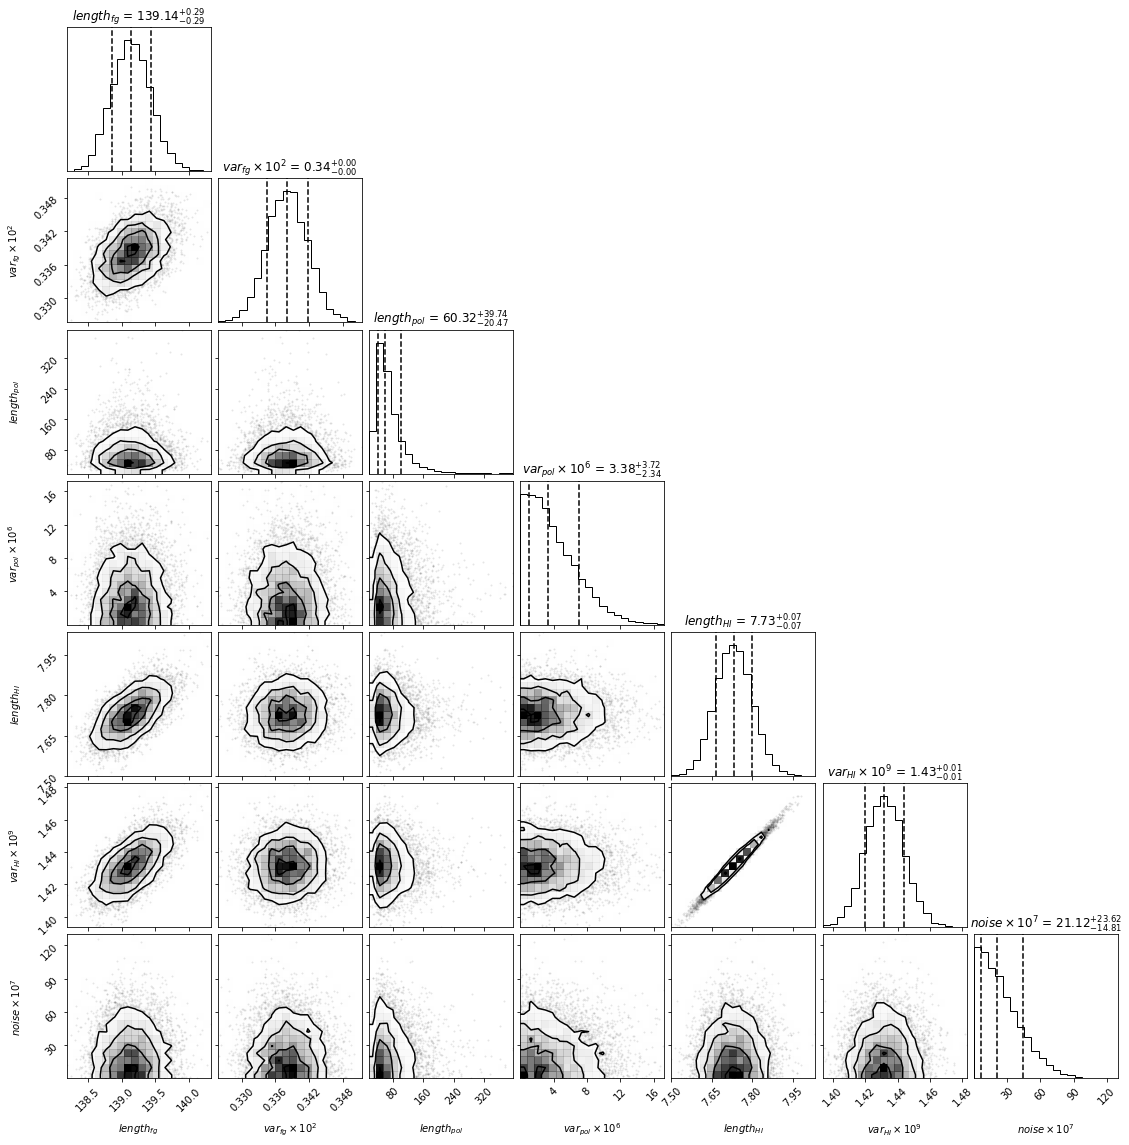

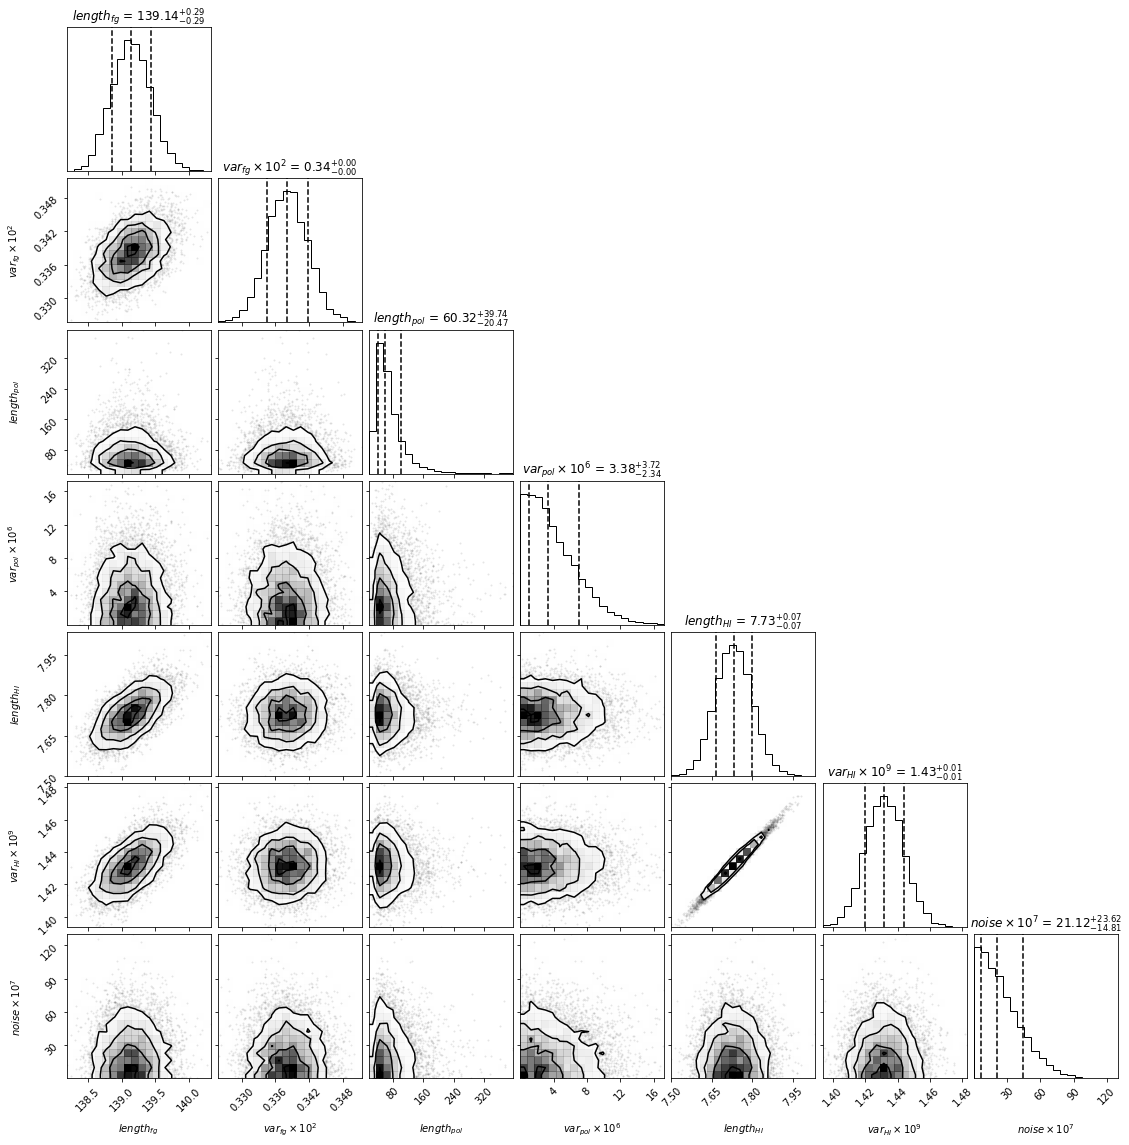

In [44]:
import corner
data = np.vstack([samples['kernel_length']*285,samples['kernel_var'],samples['kernel_lengthpol']*285,samples['kernel_varpol'],samples['kernel_lengthHI']*2.85*2,samples['kernel_varHI'],samples['kernel_noise']*100]).T
corner.corner(data,labels=[
        r"$length_{fg}$",
        r"$var_{fg}\times 10^{2}$",
        r"$length_{pol}$",
        r"$var_{pol}\times 10^{6}$",
        r"$length_{HI}$",
        r"$var_{HI}\times 10^{9}$",
        r"$noise\times 10^{7}$",
    ],quantiles=[0.16, 0.5, 0.84],show_titles=True)

In [7]:
import pandas as pd
data = pd.read_pickle('/home/dkn16/data.pkl')

In [8]:
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs

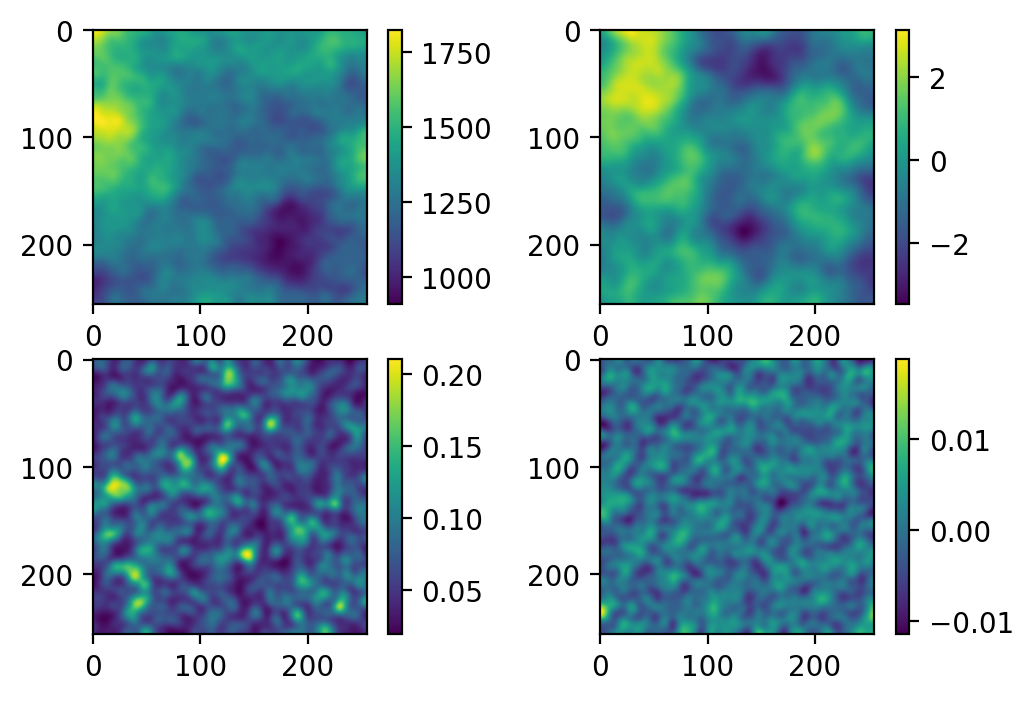

In [14]:
plt.figure(dpi=200)
plt.subplot(221)
plt.imshow(FGnopol[...,0])
plt.colorbar()
plt.subplot(222)
plt.imshow(FGpol[...,0])
plt.colorbar()
plt.subplot(223)
plt.imshow(HI[...,0])
plt.colorbar()
plt.subplot(224)
plt.imshow(noise[...,0])
plt.colorbar()

In [21]:
len(samples['kernel_var'][-1:-21:-1])

20

In [21]:
X, Y, X_test = get_data(pol=True,dim=64,x0=183,y0=0,freqs=150)
samples = jnp.load('samples.npy',allow_pickle=True).item()